# "Agrupamiento k-Means para CIFAR-10"
> Agrupamiento (clustering) basado en k-Means para CIFAR-10 y la nueva tf.numpy.


- toc: true 
- badges: true 
- comments: true
- categories: ["Computer Vision"]
- image: images/stanford.png



## 1. Introducción

Este ejemplo muestra cómo hacer un agrupamiento (clustering) para el dataset de de imágenes de Cifar-10. Nótese que esto no es un problema de clasificación, sino un clustering con un tipo de entrenamiento NO supervisado.

Diferencias entre clasificación y agrupamiento ó clustering:
* En la **clasificación**, las clases resultantes son dadas como parte del set de entrenamiento. Esta información es realmente usada durante el entrenamiento apra construir el clasificador. Posteriormente, se aplica el clasificador resultante sobre imágenes nuevas (sin clasificar previamente).  
* En el **agrupamiento**, se particionan las imágenes en varios grupos (clases resultantes). No se conoce el significado de esas clases,simplemente se sabe que estadísticamente son parecidas.
Ejemplos de redes para clasificación es una red convolucional (aprendizaje supervisado). Ejemplo de algoritmos de agrupamiento es kMeans.

En este notebook se va a usar k-Means, que es un **algoritmo de clasificación no supervisado** (clustering) que agrupa objetos en k grupos basándose en sus características. El clustering in k grupos se realiza minimizando la suma de distancias (puede ser media ó cuadrática) entre cada objeto y el centroide de su cluster.

Este ejemplo se ha probado y funciona en Colab.

## 2. Setup
Importamos las librerías que vamos a usar. Usaremos la función experimental `tensorflow.numpy` para aprovechar las GPUs durante operaciones con funciones `numpy` (por ejemplo, durante la inferencia):

In [ ]:
!pip3 install --user --upgrade tf-nightly
!pip3 install --user scikit-learn

In [33]:
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle

from tensorflow.keras import datasets, layers, models

Comprobamos si tenemos GPUs. En caso contrario, no notaremos diferencia de velocidad:

In [34]:
print("All logical devices:", tf.config.list_logical_devices())
print("All physical devices:", tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

All logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU')]
All physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs Available:  0


## 3. Carga de datos
Cargamos el dataset desde `tensorflow.keras.datasets`:

In [35]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Usando scikit-learn, Hacemos shuffle y usamos sólo 2000 imágenes para entrenar y 100 para test
train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)

train_images = train_images[:2000]
train_labels = train_labels[:2000]
test_images = test_images[:100]
test_labels = test_labels[:100]

# Normalizamos valores de píxeles entre 0 y 1
train_images, test_images = train_images / 255.0, test_images / 255.


Visualizamos los primeros 25 elementos del dataset:

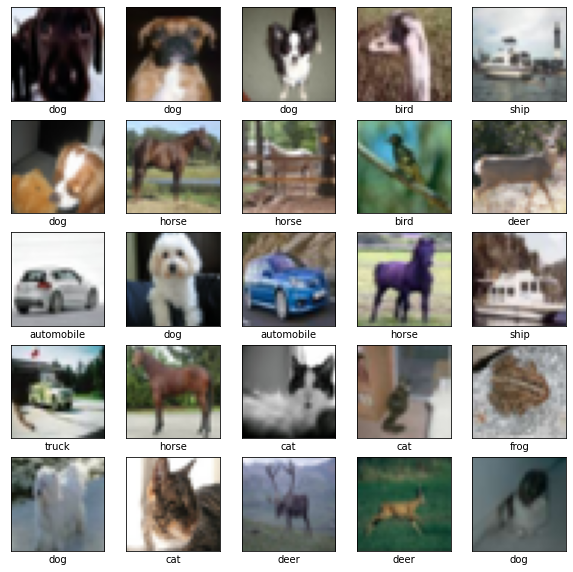

In [36]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## 4. Preparar datos
El set de entrenamiento original era de tamaño `train_images.shape=(50000,32,32,3)` y sus etiquetas `train_labels.shape=(50000, 1)`. Pero usamos uno más pequeño de 2000. Aplanamos el set de entrenamiento y también el de pruebas:

In [37]:
train_images_rows = train_images.reshape(train_images.shape[0], 32 * 32 * 3) # train_images_rows.shape 2000 x 3072
test_images_rows = test_images.reshape(test_images.shape[0], 32 * 32 * 3) # test_images_rows.shape 100 x 3072

## 5. Construcción del modelo


El algoritmo k-Means consta de tres pasos:

1. **Inicialización:** se selecciona el número de centroides (grupos, `NUM_CENTROIDS`) y se crean con el tamaño de las imágenes, aleatorios.  
2. **Asignación:** cada imagen es asignada a su centroide más cercano.  
3. **Actualización centroides:** se actualiza la posición del centroide de cada grupo tomando como nuevo centroide la posición del promedio de los objetos pertenecientes a dicho grupo.

Se repiten los pasos 2 y 3 hasta que los centroides no cambian.

Para medir la precisión, se usa la métrica **Purity**, que es una medida de evaluación muy sencilla y trasnparente, en donde se cuenta la etiqueta más frecuente en cada cluster, y se calcula la pureza dividiendo ese valor por el número total de elementos del cluster. La pureza del algoritmo es simplemente la suma de las purezas de cada cluster. En el mejor caso, para un cluster de 10 centroides, la pureza debería ser 10 (`NUM_CENTROIDS`). Una definición más formal de pureza se puede ver [aqui](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)(Stanford), donde define la **pureza** (purity) de la siguiente manera:

> To compute purity , each cluster is assigned to the class which is most frequent in the cluster, and then the accuracy of this assignment is measured by counting the number of correctly assigned documents and dividing by N.


In [38]:
# Paso 1: Inicialización
NUM_IMAGES = train_images.shape[0] # 2000
NUM_CENTROIDS = 10 # We know number of centroids beforehand

# Paso 2: Asignación a centroide más cercano
def assignment(centroids):
  closest = []

  for j in range(NUM_IMAGES):
    distances_from_centroid = []
    for i in range(NUM_CENTROIDS):
      distances_from_centroid = np.append(distances_from_centroid, np.sum(np.abs(centroids[i, :] - train_images_rows[j,:])))
    #print(distances_from_centroid)
    closest.append(np.argmin(distances_from_centroid))
  #print(closest)
  return closest

# Paso 3: Actualización centroides
def update(closest):
  purity = []
  new_centroids = np.zeros((NUM_CENTROIDS, 32*32*3))
  for c in range(NUM_CENTROIDS):
    num = 0 # num of IMAGES in the cluster
    best = []
    # Takes all images assigned to the centroid and calculates average
    for i in range(NUM_IMAGES):
      if (closest[i] == c):
        num = num + 1
        #print(train_images_rows[i, :])
        new_centroids[c, :] += train_images_rows[i, :]
        best = np.append(best, train_labels[i])

    # Discard if there are no images (num=0) assigned to a centroid
    # Calculate average
    if (num>0):
      new_centroids[c, :] = new_centroids[c, :] / num

    # Calculate PURITY for each cluster separately
    # Note clusters do not follow label ordering of train images, so cluster 0 does not equal to label_0 (airplane)
    unique, counts = np.unique(best, return_counts=True)
    #print("Cluster ", c ," has ", num, " images assigned. Most frequent label is: ", unique[counts == counts.max()])
    #print(dict(zip(unique, counts)))
    correct_label_count = 0
    # Fix case where two or more labels are the most frequent in a cluster simultaneously
    if (unique[counts == counts.max()].size > 1):
      best_label = unique[counts == counts.max()][0]
    else:
      best_label = unique[counts == counts.max()]
    # Calculate accuracy of each cluster
    for i in range(NUM_IMAGES):
        if (closest[i] == c):
            if (best_label != train_labels[i]):
                correct_label_count += 1
    purity = np.append(purity, correct_label_count/num)
  return new_centroids, purity  


In [39]:
# Ejecución del algoritmo k-Means: bucle hasta que los centroides no cambian
centroides = np.random.rand(NUM_CENTROIDS, 32*32*3)
while True:
    cercanos = assignment(centroides)
    nuevos_centroides, pureza = update(cercanos)
    print("Purity: ", np.sum(pureza), " Centroids convergence: ", np.sum(nuevos_centroides)-np.sum(centroides))
    if (np.allclose(nuevos_centroides, centroides)):
      break
    centroides = nuevos_centroides

Purity:  7.9965560089395655  Centroids convergence:  -746.7084560363146
Purity:  7.943196142923129  Centroids convergence:  119.4648817833222
Purity:  7.9039324746096895  Centroids convergence:  62.28089489692866
Purity:  7.932367161887371  Centroids convergence:  31.140070249635755
Purity:  7.9039930061718495  Centroids convergence:  -0.1451568159063754
Purity:  7.820340715091028  Centroids convergence:  8.414687342308753
Purity:  7.765830216830343  Centroids convergence:  13.7974994320939
Purity:  7.738011137207956  Centroids convergence:  15.081796966322145
Purity:  7.69773014520016  Centroids convergence:  5.673767774393127
Purity:  7.696702062400967  Centroids convergence:  7.974471169105527
Purity:  7.700918415512169  Centroids convergence:  18.8741719596419
Purity:  7.65497755851878  Centroids convergence:  33.023605037980815
Purity:  7.63115601435065  Centroids convergence:  22.562264748125017
Purity:  7.617719944540954  Centroids convergence:  26.744554495204284
Purity:  7.610

En el paso 2 anterior (asignación de centroides), se puede usar la distancia L1 ó L2 (cuadrática). Para la diferencia cuadrática, simplemente cambiar la línea  por la siguiente:
`distances_from_centroid.append(np.sqrt(np.sum(np.abs(centroids[i, :] - train_images_rows[j,:]))))`

## 6. Evaluación
La pureza (purity) la obtuvimos en el paso anterior. Cada cluster no sigue el orden de las etiquetas  del dataset, es decir, el cluster 0 no corresponde a la clase `airplane`. Mostramos las 25 primeras imágenes del **Cluster 0**, aunque esto no es representativo ya que la precisión es baja y no estamos viendo todas las imágenes del cluster 0:

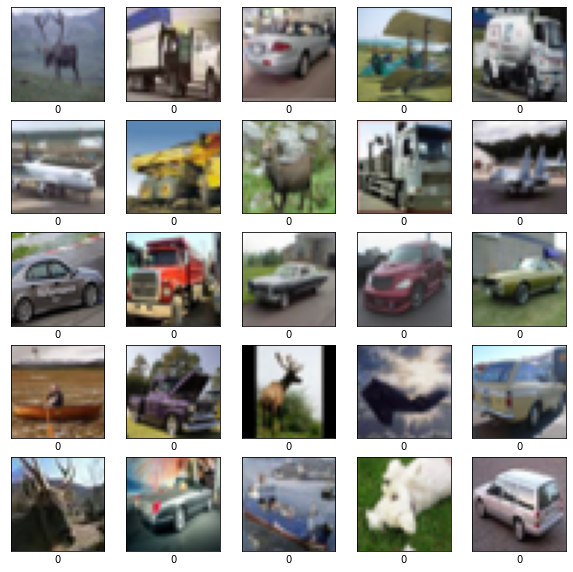

In [40]:
CENTROID_TO_EVALUATE = 0 # Cluster a mostrar
train_images_rows_img = train_images_rows.reshape(train_images_rows.shape[0], 32, 32, 3)

plt.figure(figsize=(10,10))
num = 0
for i in range(NUM_IMAGES):
    if (num == 25):
        break
    if (cercanos[i] == CENTROID_TO_EVALUATE):
        plt.subplot(5,5,num+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images_rows_img[i], cmap=plt.cm.binary)
        plt.xlabel(cercanos[i])
        num += 1

Como curiosidad, vemos los 10 centroides generados y mostramos sus imágenes:



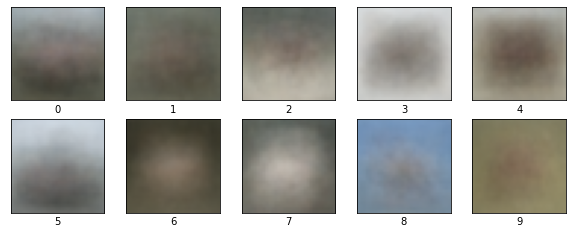

In [41]:
centroides_img = nuevos_centroides.reshape(nuevos_centroides.shape[0], 32, 32, 3)

plt.figure(figsize=(10,10))
for c in range(NUM_CENTROIDS):
    plt.subplot(5,5,c+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(centroides_img[c], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(c)
plt.show()